In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Calculate Symptoms Combination

In [ ]:
from math import comb

# Total number of symptoms
n = 12

# Maximum combination size
max_r = 5

# Calculate total combinations
total_combinations = sum(comb(n, r) for r in range(1, max_r + 1))

print(f"Total combinations for up to {max_r} symptoms from {n} symptoms: {total_combinations}")

In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/P2/T1/Dataset/2no_zero.csv')
print(data.info())

# 3.0 Making Combination

In [ ]:
import pandas as pd
from itertools import combinations
from sklearn.utils import resample

# Define combination limits
combination_limits = {
    9: 9,   #  9 x 9 = 511
    10: 6,  # 10 x 4 = 385, 10 x 5 = 637, 10 x 6 = 847
    11: 5,  # 11 x 4 = 561, 11 x 5 = 1023
    12: 5,  # 12 x 3 = 298, 12 x 4 = 793, 12x5 = 1585
    13: 4,  # 13 x 3 = 377, 13 x 4 = 1092
}

# Set target sample limits
min_samples = 500
max_samples = 1100

# Initialize a list to store the expanded dataset
balanced_data = []

# Iterate through each disease
for _, row in data.iterrows():
    symptoms = row[:-1]  # All symptom columns (exclude disease_label)
    disease = row[-1]  # Disease label

    # Find symptoms associated with the disease (value == 1)
    present_symptoms = symptoms[symptoms == 1].index.tolist()
    num_symptoms = len(present_symptoms)

    # Get the combination limit for this disease
    max_comb_size = combination_limits.get(num_symptoms, min(num_symptoms, 3))  # Default to 3 if not specified

    # Generate combinations of symptoms up to max_comb_size
    all_combinations = []
    for r in range(1, min(len(present_symptoms), max_comb_size) + 1):
        combs = list(combinations(present_symptoms, r))
        all_combinations.extend(combs)

    # Convert combinations into rows
    disease_rows = []
    for comb in all_combinations:
        new_row = {symptom: 1 if symptom in comb else 0 for symptom in symptoms.index}
        new_row["disease_label"] = disease
        disease_rows.append(new_row)

    # Create a DataFrame for this disease
    disease_df = pd.DataFrame(disease_rows)

    # Oversample or undersample to target range
    if len(disease_df) < min_samples:
        # Oversample with replacement to reach min_samples
        disease_df = resample(disease_df, replace=True, n_samples=min_samples, random_state=42)
    elif len(disease_df) > max_samples:
        # Undersample without replacement to max_samples
        disease_df = disease_df.sample(n=max_samples, random_state=42)

    # Append the balanced data for this disease
    balanced_data.append(disease_df)

# Combine all diseases into a single DataFrame
final_balanced_df = pd.concat(balanced_data).reset_index(drop=True)

# Save the final balanced dataset
final_balanced_df.to_csv("/content/drive/MyDrive/P2/T1/Dataset/3sym_combined.csv", index=False)
print(f"Balanced dataset saved with {final_balanced_df.shape[0]} samples.")


# 4.0 Splitting overlapping and non-overlapping symptoms combinations

In [ ]:
import pandas as pd

# Load the expanded dataset
file_path = "/content/drive/MyDrive/P2/T1/Dataset/3sym_combined.csv"
data = pd.read_csv(file_path)

# Separate symptoms columns and the disease label
symptoms_columns = [col for col in data.columns if col != "disease_label"]

# Find duplicate rows based on symptoms with different disease labels (overlapping/conflicting samples)
duplicates = data[data.duplicated(subset=symptoms_columns, keep=False)]  # All duplicates
duplicates = duplicates.copy()
duplicates["symptom_combination"] = duplicates[symptoms_columns].apply(
    lambda row: ', '.join(row.index[row == 1]), axis=1
)
conflicting_diseases = duplicates.groupby("symptom_combination")["disease_label"].transform(
    lambda x: ' > '.join(x.unique())
)
duplicates["conflicting_diseases"] = conflicting_diseases
duplicates = duplicates.sort_values(by="symptom_combination").reset_index(drop=True)

# Save the conflicting (overlapping) samples
conflicting_samples_file_path = "/content/drive/MyDrive/P2/T1/Dataset/4overlapped.csv"
duplicates.to_csv(conflicting_samples_file_path, index=False)
print(f"Processed conflicting (overlapped) samples saved to {conflicting_samples_file_path}.")

# Identify non-conflicting (unique) samples using symptom combinations
non_duplicates = data[~data[symptoms_columns].apply(tuple, axis=1).isin(duplicates[symptoms_columns].apply(tuple, axis=1))]
non_duplicates = non_duplicates.copy()
non_duplicates["symptom_combination"] = non_duplicates[symptoms_columns].apply(
    lambda row: ', '.join(row.index[row == 1]), axis=1
)
non_duplicates["conflicting_diseases"] = non_duplicates["disease_label"]  # No conflicts, so this is the same as the disease_label

# Save the non-conflicting samples
non_conflicting_samples_file_path = "/content/drive/MyDrive/P2/T1/Dataset/4non_overlapped.csv"
non_duplicates.to_csv(non_conflicting_samples_file_path, index=False)
print(f"Processed non-conflicting (unique) samples saved to {non_conflicting_samples_file_path}.")


Processed conflicting (overlapped) samples saved to /content/drive/MyDrive/P2/T1/Dataset/4overlapped.csv.
Processed non-conflicting (unique) samples saved to /content/drive/MyDrive/P2/T1/Dataset/4non_overlapped.csv.


In [ ]:
# Load the saved file and check for duplicates
non_overlapped_data = pd.read_csv("/content/drive/MyDrive/P2/T1/Dataset/4non_overlapped.csv")
duplicate_check = non_overlapped_data[non_overlapped_data.duplicated(subset=symptoms_columns, keep=False)]
print(duplicate_check.shape)  # Should output (0, X) if no duplicates exist


(0, 274)


# Visualize the data distribution

Total number of rows in the dataset: 2266


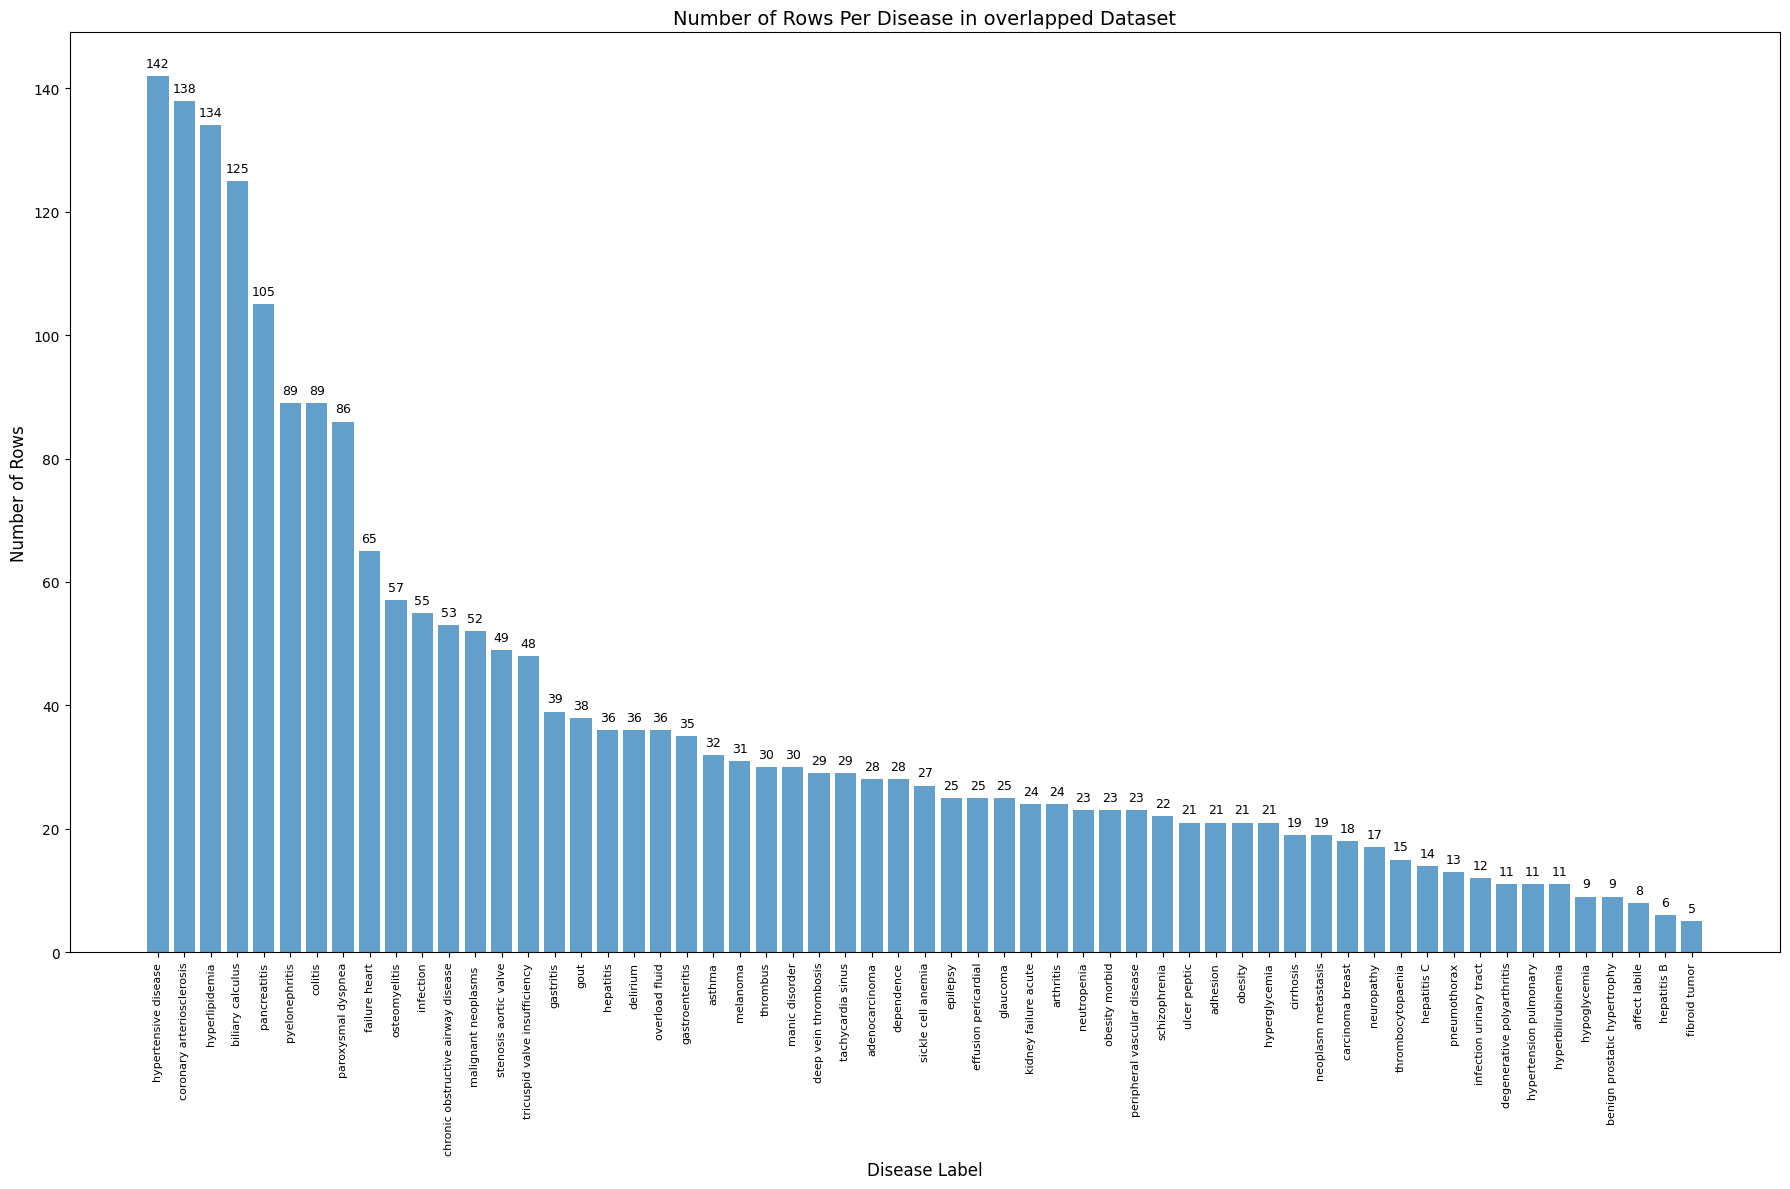

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the expanded dataset
expanded_df = pd.read_csv("/content/drive/MyDrive/P2/T1/Dataset/4overlapped.csv")

# Print the total number of rows in the CSV file
total_rows = len(expanded_df)
print(f"Total number of rows in the dataset: {total_rows}")

# Group the expanded dataset by disease to count rows per disease
disease_distribution = expanded_df["disease_label"].value_counts()

# Create a bar graph
plt.figure(figsize=(18, 12))
bars = plt.bar(disease_distribution.index, disease_distribution.values, alpha=0.7)

# Add row counts on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Customize the plot
plt.title("Number of Rows Per Disease in overlapped Dataset", fontsize=14)
plt.xlabel("Disease Label", fontsize=12)
plt.ylabel("Number of Rows", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Load the filtered dataset
filtered_df = pd.read_csv("/content/drive/MyDrive/P2/Dataset/DiseasePrediction2/ML/expanded_dataset.csv")

# Calculate the distribution of diseases
filtered_disease_distribution = filtered_df["disease_label"].value_counts()

print("The total number of disease_label: ", len(filtered_disease_distribution))

# Create a bar chart using Plotly
fig = px.bar(
    x=filtered_disease_distribution.index,
    y=filtered_disease_distribution.values,
    labels={"x": "Disease Label", "y": "Number of Rows"},
    title="Distribution of Diseases in Filtered Dataset",
    text=filtered_disease_distribution.values,
    color=filtered_disease_distribution.values,
    color_continuous_scale="sunset"
)

# Customize the layout
fig.update_layout(
    xaxis_title="Disease Label",
    yaxis_title="Number of Rows",
    xaxis=dict(tickangle=45),
    title_font_size=20,
    template="plotly_dark"
)

# Show the chart
fig.show()

The total number of disease_label:  59


# 5.0 Extract 15% for both Validation and Testing_dataset

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/P2/T1/Dataset/4overlapped.csv")

# Set the percentage of samples for testing and validation
test_ratio = 0.10  # 10% for testing
val_ratio = 0.10   # 10% for validation
min_samples = 1    # Ensure at least one sample per split

# Initialize lists to hold training, validation, and testing data
training_data = []
validation_data = []
testing_data = []

# Group by disease and split ensuring all diseases are represented
for disease, group in data.groupby("disease_label"):
    total_samples = len(group)
    test_samples = max(int(total_samples * test_ratio), min_samples)
    val_samples = max(int(total_samples * val_ratio), min_samples)

    if total_samples > (test_samples + val_samples):
        # Ensure sufficient samples for training
        test_group = group.sample(n=test_samples, random_state=42)
        remaining_group = group.drop(test_group.index)
        val_group = remaining_group.sample(n=val_samples, random_state=42)
        train_group = remaining_group.drop(val_group.index)
    else:
        # If insufficient samples, split unevenly but ensure representation
        test_group = group.sample(n=min(min_samples, total_samples - 1), random_state=42)
        remaining_group = group.drop(test_group.index)
        val_group = remaining_group.sample(n=min(min_samples, len(remaining_group)), random_state=42)
        train_group = remaining_group.drop(val_group.index)

    testing_data.append(test_group)
    validation_data.append(val_group)
    training_data.append(train_group)

# Combine all splits into final datasets
training_dataset = pd.concat(training_data).reset_index(drop=True)
validation_dataset = pd.concat(validation_data).reset_index(drop=True)
testing_dataset = pd.concat(testing_data).reset_index(drop=True)

# Save the datasets to separate files
training_dataset.to_csv("/content/drive/MyDrive/P2/T1/Dataset/over_training_ML.csv", index=False)
validation_dataset.to_csv("/content/drive/MyDrive/P2/T1/Dataset/over_validation_ML.csv", index=False)
testing_dataset.to_csv("/content/drive/MyDrive/P2/T1/Dataset/over_testing_ML.csv", index=False)

# Print confirmation and data distribution
print(f"Training dataset saved with {training_dataset.shape[0]} samples.")
print(f"Validation dataset saved with {validation_dataset.shape[0]} samples.")
print(f"Testing dataset saved with {testing_dataset.shape[0]} samples.")

# Optionally, print class distributions
print("\nTraining Data Distribution:")
print(training_dataset['disease_label'].value_counts())

print("\nValidation Data Distribution:")
print(validation_dataset['disease_label'].value_counts())

print("\nTesting Data Distribution:")
print(testing_dataset['disease_label'].value_counts())


Training dataset saved with 1862 samples.
Validation dataset saved with 202 samples.
Testing dataset saved with 202 samples.

Training Data Distribution:
disease_label
hypertensive disease                  114
coronary arteriosclerosis             112
hyperlipidemia                        108
biliary calculus                      101
pancreatitis                           85
pyelonephritis                         73
colitis                                73
paroxysmal dyspnea                     70
failure heart                          53
osteomyelitis                          47
infection                              45
chronic obstructive airway disease     43
malignant neoplasms                    42
stenosis aortic valve                  41
tricuspid valve insufficiency          40
gastritis                              33
gout                                   32
delirium                               30
overload fluid                         30
hepatitis                         

In [ ]:
# Validate the number of unique disease labels
training_labels = set(training_dataset["disease_label"].unique())
testing_labels = set(testing_dataset["disease_label"].unique())

if training_labels == testing_labels:
    print("Both training and testing datasets have all same disease labels.")
else:
    missing_in_training = testing_labels - training_labels
    missing_in_testing = training_labels - testing_labels
    print(f"Labels missing in training dataset: {missing_in_training}")
    print(f"Labels missing in testing dataset: {missing_in_testing}")


Both training and testing datasets have all same disease labels.


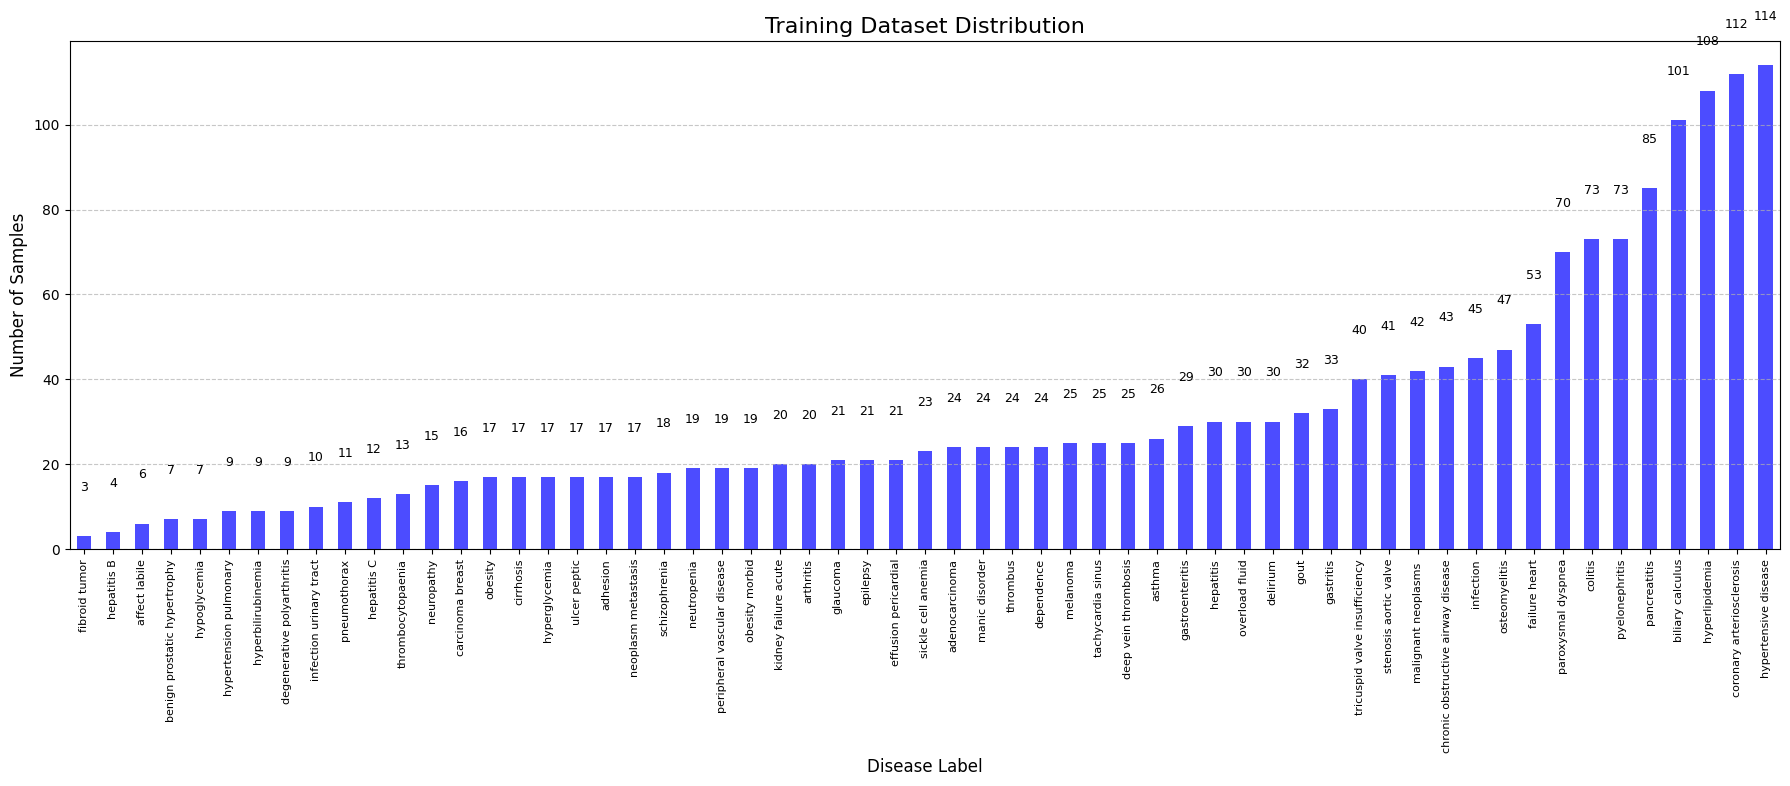

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training dataset
training_dataset = pd.read_csv("/content/drive/MyDrive/P2/T1/Dataset/training_ML.csvv")

# Plot the distribution of diseases in the training dataset
def plot_training_distribution(data, title):
    disease_counts = data['disease_label'].value_counts().sort_values()
    plt.figure(figsize=(18, 8))
    bars = disease_counts.plot(kind='bar', color='blue', alpha=0.7)

    # Add the number of rows on top of each bar
    for index, value in enumerate(disease_counts):
        plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=9)

    # Customize the plot
    plt.title(title, fontsize=16)
    plt.xlabel("Disease Label", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the plotting function for training dataset
plot_training_distribution(training_dataset, "Training Dataset Distribution")


In [ ]:
print(training_dataset["disease_label"].value_counts())
print(testing_dataset["disease_label"].value_counts())

disease_label
adenocarcinoma                        874
adhesion                              874
colitis                               874
fibroid tumor                         874
epilepsy                              874
dependence                            874
delirium                              874
manic disorder                        874
obesity                               874
hypertensive disease                  874
hyperlipidemia                        874
obesity morbid                        874
tachycardia sinus                     874
neutropenia                           874
malignant neoplasms                   819
thrombus                              819
stenosis aortic valve                 819
sickle cell anemia                    819
peripheral vascular disease           819
degenerative polyarthritis            819
gastroenteritis                       819
hepatitis C                           819
hypoglycemia                          819
failure heart       

In [ ]:
# Get unique values in the "prognosis" column
unique_labels = testing_dataset['disease_label'].unique()

# Print the unique labels
print(unique_labels)

print(len(unique_labels))

['adenocarcinoma' 'adhesion' 'affect labile' 'arthritis' 'asthma'
 'benign prostatic hypertrophy' 'biliary calculus' 'carcinoma breast'
 'chronic obstructive airway disease' 'cirrhosis' 'colitis'
 'coronary arteriosclerosis' 'deep vein thrombosis'
 'degenerative polyarthritis' 'delirium' 'dependence'
 'effusion pericardial' 'epilepsy' 'failure heart' 'fibroid tumor'
 'gastritis' 'gastroenteritis' 'glaucoma' 'gout' 'hepatitis' 'hepatitis B'
 'hepatitis C' 'hyperbilirubinemia' 'hyperglycemia' 'hyperlipidemia'
 'hypertension pulmonary' 'hypertensive disease' 'hypoglycemia'
 'infection' 'infection urinary tract' 'kidney failure acute'
 'malignant neoplasms ' 'manic disorder' 'melanoma' 'neoplasm metastasis'
 'neuropathy' 'neutropenia' 'obesity' 'obesity morbid' 'osteomyelitis'
 'overload fluid' 'pancreatitis' 'paroxysmal dyspnea'
 'peripheral vascular disease' 'pneumothorax' 'pyelonephritis'
 'schizophrenia' 'sickle cell anemia' 'stenosis aortic valve'
 'tachycardia sinus' 'thrombocytopaen

# 6.0 Oversampling minor classes for Training dataset

In [ ]:
"""
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/P2/Dataset/DiseasePrediction2/ML/training_ML.csv')

# Separate features and target
X = data.iloc[:, :-1]  # Features
y = data["disease_label"]  # Target (class labels)

# Define a dictionary with class labels and their respective target sizes
# For SMOTE, use the class label (not the number of samples)
sampling_strategy = {
    'neoplasm metastasis': 400,
    'gout': 400,
    'tricuspid valve insufficiency': 400,
    'glaucoma': 400,
    'kidney failure acute': 400,
    'neuropathy': 400,
    'pyelonephritis': 400,
    'coronary arteriosclerosis': 400,
    'chronic obstructive airway disease': 400,
    'arthritis': 400,
}

# Apply SMOTE for oversampling
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the oversampled features and target into a new DataFrame
final_oversampled_data = pd.concat(
    [pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=["disease_label"])],
    axis=1
)

# Save the oversampled dataset (optional)
final_oversampled_data.to_csv('/content/drive/MyDrive/P2/Dataset/DiseasePrediction2/ML/ostraining_ML.csv', index=False)

# Visualize the new distribution
def plot_distribution(data, title):
    disease_counts = data['disease_label'].value_counts().sort_values()
    plt.figure(figsize=(18, 8))
    bars = disease_counts.plot(kind='bar', color='blue', alpha=0.7)

    # Add the number of rows on top of each bar
    for index, value in enumerate(disease_counts):
        plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=9)

    # Customize the plot
    plt.title(title, fontsize=16)
    plt.xlabel("Disease Label", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot the distribution after SMOTE oversampling
plot_distribution(final_oversampled_data, "Distribution of Samples After SMOTE Oversampling")
"""

'\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom imblearn.over_sampling import SMOTE\n\n# Load the dataset\ndata = pd.read_csv(\'/content/drive/MyDrive/P2/Dataset/DiseasePrediction2/ML/training_ML.csv\')\n\n# Separate features and target\nX = data.iloc[:, :-1]  # Features\ny = data["disease_label"]  # Target (class labels)\n\n# Define a dictionary with class labels and their respective target sizes\n# For SMOTE, use the class label (not the number of samples)\nsampling_strategy = {\n    \'neoplasm metastasis\': 400,\n    \'gout\': 400,\n    \'tricuspid valve insufficiency\': 400,\n    \'glaucoma\': 400,\n    \'kidney failure acute\': 400,\n    \'neuropathy\': 400,\n    \'pyelonephritis\': 400,\n    \'coronary arteriosclerosis\': 400,\n    \'chronic obstructive airway disease\': 400,\n    \'arthritis\': 400,\n}\n\n# Apply SMOTE for oversampling\nsmote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)\nX_resampled, y_resampled = smote.fit_resample(X, y)\n\n# Comb

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


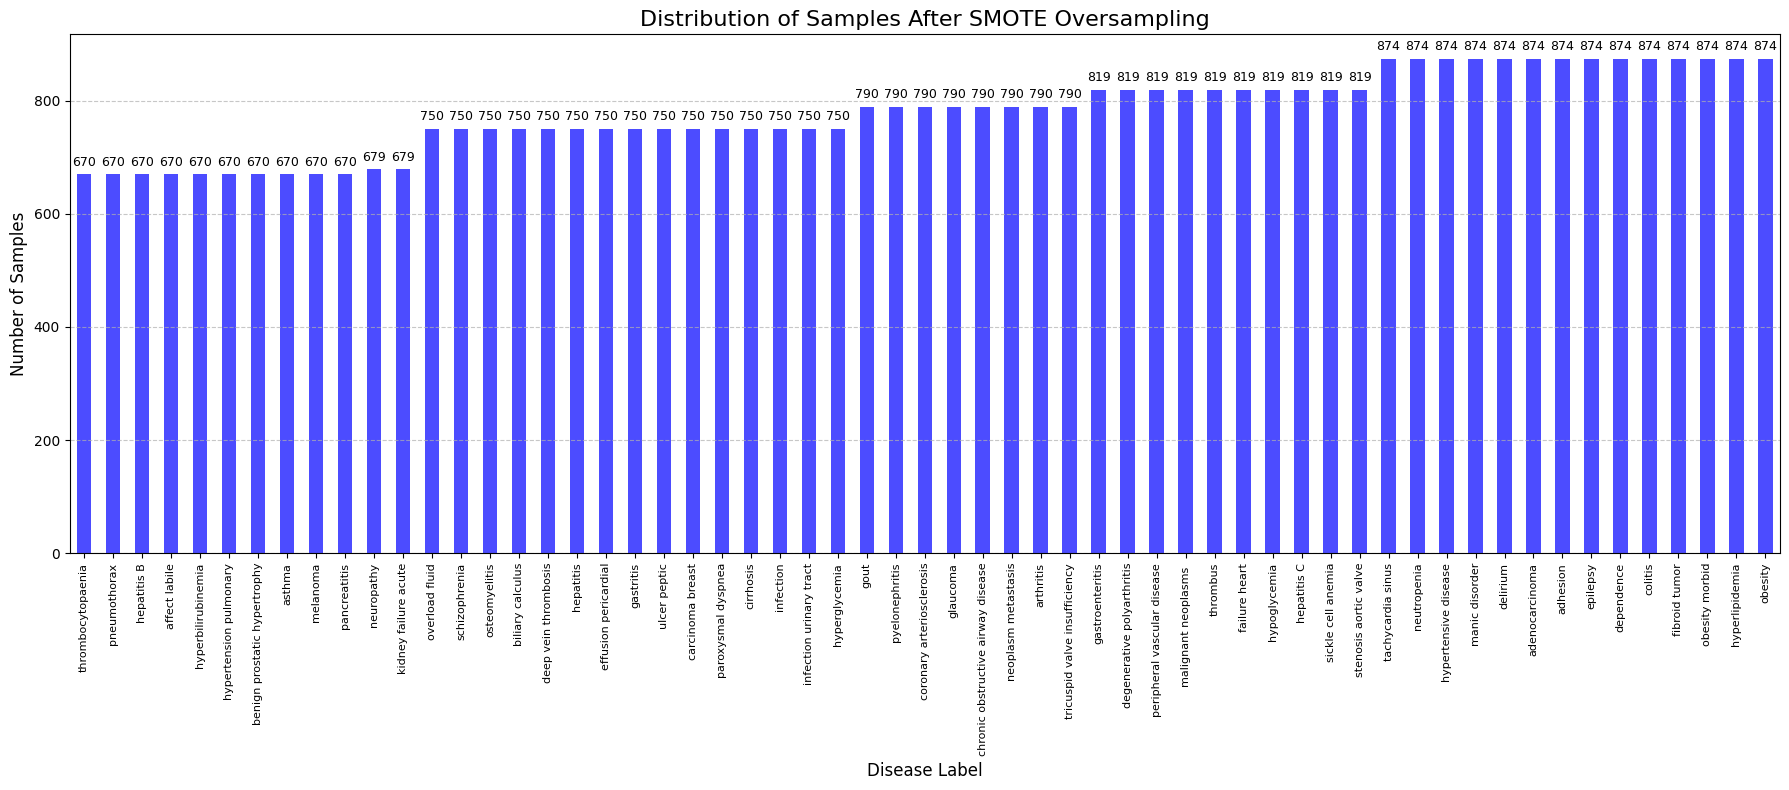

In [ ]:
"""
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/P2/Dataset/DiseasePrediction2/ML/training_ML.csv')

# Separate features and target
X = data.iloc[:, :-1]  # Features
y = data["disease_label"]  # Target (class labels)

# Define a dictionary with class labels and their respective target sizes
# For SMOTE, use the class label (not the number of samples)
sampling_strategy = {
    'thrombocytopaenia': 670,
    'pneumothorax': 670,
    'hepatitis B': 670,
    'affect labile': 670,
    'hyperbilirubinemia': 670,
    'hypertension pulmonary': 670,
    'benign prostatic hypertrophy': 670,
    'asthma': 670,
    'melanoma': 670,
    'pancreatitis': 670,
    'biliary calculus': 750,
    'carcinoma breast': 750,
    'osteomyelitis': 750,
    'cirrhosis': 750,
    'deep vein thrombosis': 750,
    'schizophrenia': 750,
    'paroxysmal dyspnea': 750,
    'overload fluid': 750,
    'effusion pericardial': 750,
    'ulcer peptic': 750,
    'infection urinary tract': 750,
    'infection': 750,
    'gastritis': 750,
    'hyperglycemia': 750,
    'hepatitis': 750,
    'gout' : 790,
    'glaucoma' : 790,
    'coronary arteriosclerosis' : 790,
    'tricuspid valve insufficiency' : 790,
    'neoplasm metastasis' : 790,
    'arthritis' : 790,
    'pyelonephritis' : 790,
    'chronic obstructive airway disease' : 790,
}

# Apply SMOTE for oversampling
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the oversampled features and target into a new DataFrame
final_oversampled_data = pd.concat(
    [pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=["disease_label"])],
    axis=1
)

# Save the oversampled dataset (optional)
final_oversampled_data.to_csv('/content/drive/MyDrive/P2/Dataset/DiseasePrediction2/ML/ostraining_ML.csv', index=False)

# Visualize the new distribution
def plot_distribution(data, title):
    disease_counts = data['disease_label'].value_counts().sort_values()
    plt.figure(figsize=(18, 8))
    bars = disease_counts.plot(kind='bar', color='blue', alpha=0.7)

    # Add the number of rows on top of each bar
    for index, value in enumerate(disease_counts):
        plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=9)

    # Customize the plot
    plt.title(title, fontsize=16)
    plt.xlabel("Disease Label", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot the distribution after SMOTE oversampling
plot_distribution(final_oversampled_data, "Distribution of Samples After SMOTE Oversampling")
"""